In [2]:
#install.packages("sparklyr")
library(tidyverse)
library(sparklyr)
library(DBI)
options(repr.plot.width = 12, repr.plot.height = 8)

In [3]:
spark_install()

In [4]:
df = read_csv("../input/sparkchurn/Churn_Spark.csv")
df %>% head()

New names:
• `` -> `...1`
Rows: 5037 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Geography, Gender
dbl (11): ...1, CustomerId, CreditScore, Age, Tenure, Balance, NumOfProducts...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15634602,619,France,Female,42,2,0.0,1,1,1,101348.88,1
2,15619304,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,15574012,645,Spain,Male,44,8,113755.8,2,1,0,149756.71,1
4,15656148,376,Germany,Female,29,4,115046.7,4,1,0,119346.88,1
5,15737452,653,Germany,Male,58,1,132602.9,1,1,0,5097.67,1
6,15699309,510,Spain,Female,38,4,0.0,1,1,0,118913.53,1


In [5]:
df[,1] = NULL
df %>% head()

CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15634602,619,France,Female,42,2,0.0,1,1,1,101348.88,1
15619304,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
15574012,645,Spain,Male,44,8,113755.8,2,1,0,149756.71,1
15656148,376,Germany,Female,29,4,115046.7,4,1,0,119346.88,1
15737452,653,Germany,Male,58,1,132602.9,1,1,0,5097.67,1
15699309,510,Spain,Female,38,4,0.0,1,1,0,118913.53,1


In [6]:
sc <- spark_connect(master = 'local')

# Spark SQL

In [7]:
churn_tbl <- sdf_copy_to(sc, df, "ChurnTable")

In [8]:
churn_tbl %>% head()

# Source: spark<?> [?? x 12]
  CustomerId Credi…¹ Geogr…² Gender   Age Tenure Balance NumOf…³ HasCr…⁴ IsAct…⁵
       <dbl>   <dbl> <chr>   <chr>  <dbl>  <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
1   15634602     619 France  Female    42      2      0        1       1       1
2   15619304     502 France  Female    42      8 159661.       3       1       0
3   15574012     645 Spain   Male      44      8 113756.       2       1       0
4   15656148     376 Germany Female    29      4 115047.       4       1       0
5   15737452     653 Germany Male      58      1 132603.       1       1       0
6   15699309     510 Spain   Female    38      4      0        1       1       0
# … with 2 more variables: EstimatedSalary <dbl>, Exited <dbl>, and abbreviated
#   variable names ¹​CreditScore, ²​Geography, ³​NumOfProducts, ⁴​HasCrCard,
#   ⁵​IsActiveMember
# ℹ Use `colnames()` to see all variable names

In [9]:
dbGetQuery(sc, "SELECT * FROM ChurnTable LIMIT 6")

CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15634602,619,France,Female,42,2,0.0,1,1,1,101348.88,1
15619304,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
15574012,645,Spain,Male,44,8,113755.8,2,1,0,149756.71,1
15656148,376,Germany,Female,29,4,115046.7,4,1,0,119346.88,1
15737452,653,Germany,Male,58,1,132602.9,1,1,0,5097.67,1
15699309,510,Spain,Female,38,4,0.0,1,1,0,118913.53,1


In [10]:
dbGetQuery(sc, "SELECT 
Gender, AVG(EstimatedSalary) AS mean_salary 
FROM 
ChurnTable 
GROUP BY Gender")

Gender,mean_salary
<chr>,<dbl>
Female,102102.90
Male,99811.12


In [11]:
dbGetQuery(sc, "SELECT 
Geography, AVG(Age) AS mean_age 
FROM 
ChurnTable 
GROUP BY Geography ORDER BY mean_age")

Geography,mean_age
<chr>,<dbl>
France,40.02578
Spain,40.37074
Germany,41.49265


In [13]:
dbGetQuery(sc, " SELECT * 
FROM 
ChurnTable 
WHERE Geography = 'Spain' 
AND 
Balance > (SELECT AVG(Balance) AS mean_balance FROM ChurnTable WHERE Geography = 'Spain') limit 10")

CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
15762418,750,Spain,Male,22,3,121681.82,1,1,0,128643.35,1
15613854,622,Spain,Female,46,4,107073.27,2,1,1,30984.59,1
15594408,584,Spain,Female,48,2,213146.20,1,1,0,75161.25,1
15640905,579,Spain,Female,35,1,129490.36,2,0,1,8590.83,1
15658929,683,Spain,Male,29,0,133702.89,1,1,0,55582.54,1
15755262,608,Spain,Female,41,3,89763.84,1,0,0,199304.74,1
15590241,750,Spain,Female,34,9,112822.26,1,0,0,150401.53,1
15636624,805,Spain,Female,39,5,165272.13,1,1,0,14109.85,1


# Big Data Visualization

In [14]:
churn_tbl %>% is.na() %>% sum()

[1] 0

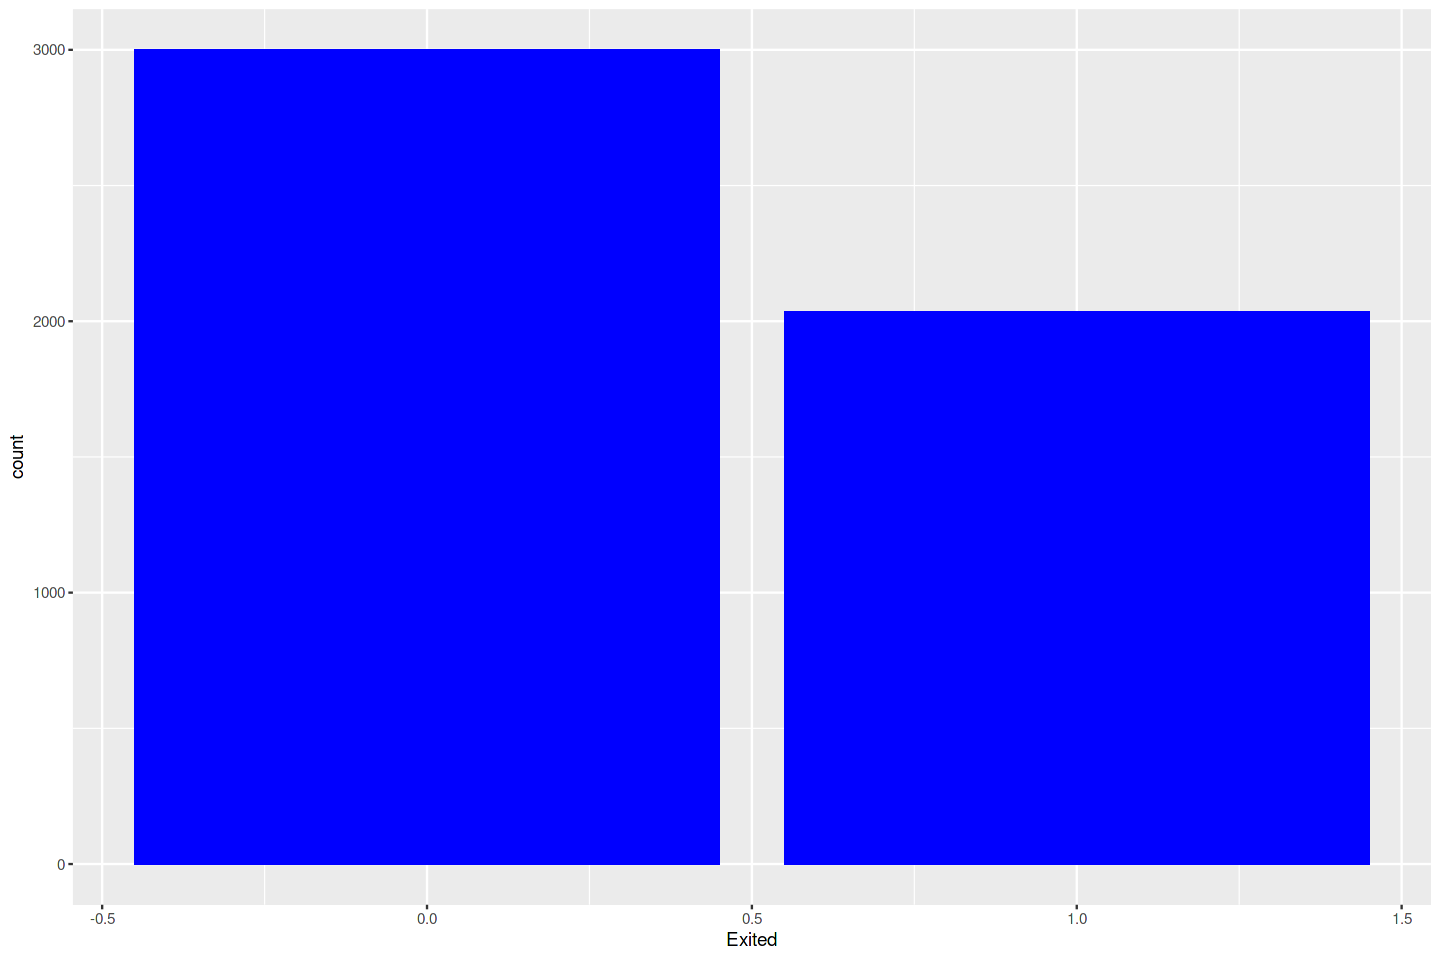

In [15]:
churn_tbl %>% ggplot(., aes(x = Exited)) + geom_bar(fill = 'blue')

Data is balanced. No need for any balancing method

Warning message:
“Missing values are always removed in SQL aggregation functions.
Use `na.rm = TRUE` to silence this warning
This warning is displayed once every 8 hours.”


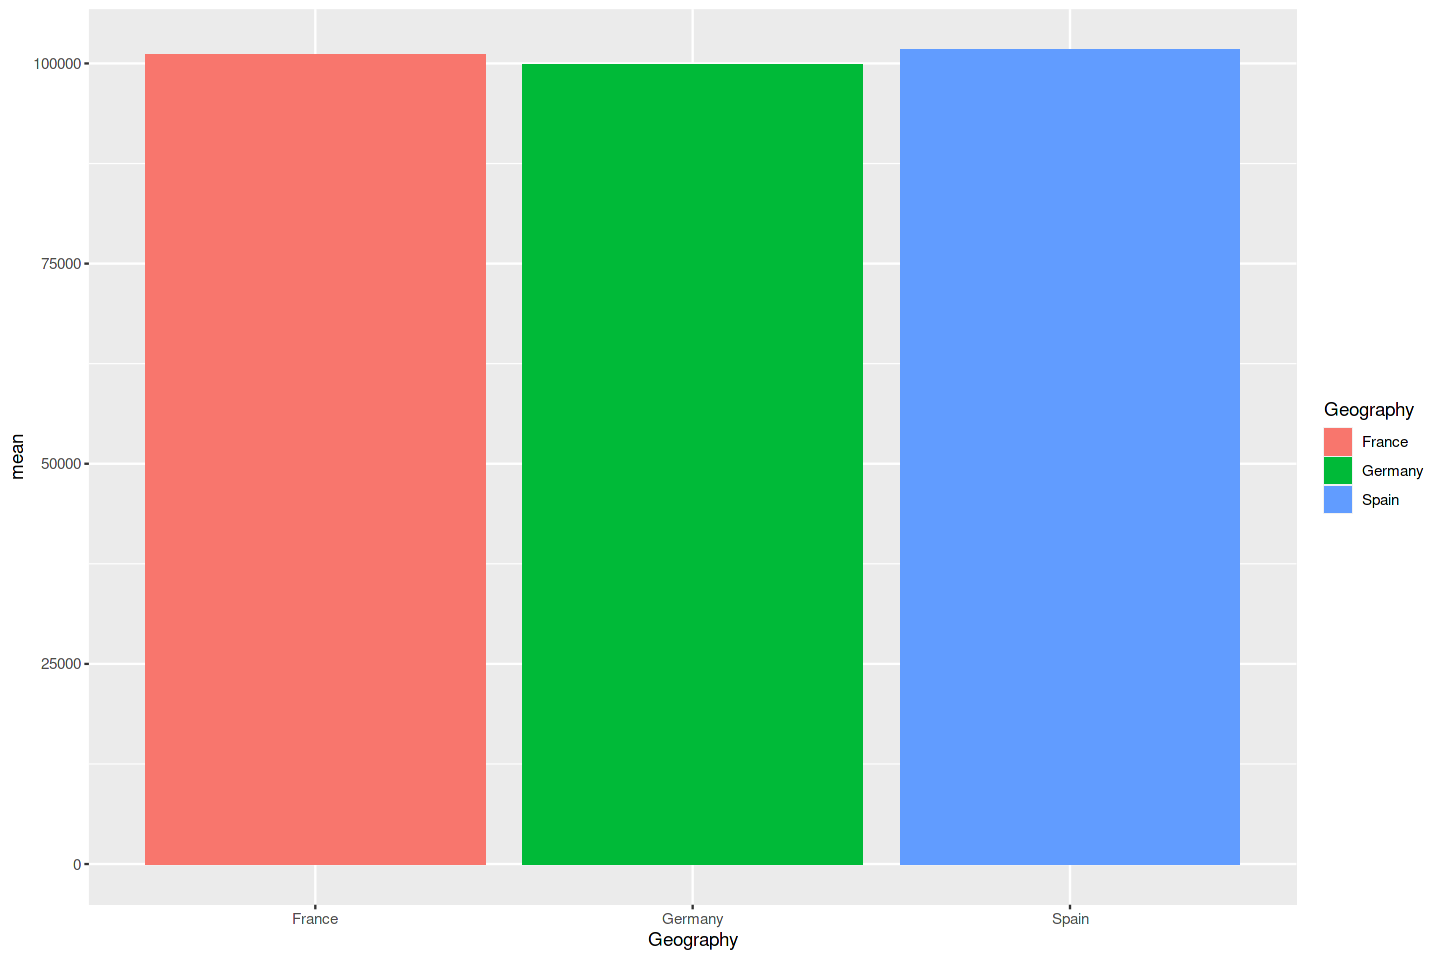

In [16]:
churn_tbl %>% group_by(Geography) %>% summarize(mean = mean(EstimatedSalary)) %>%
ggplot(., aes(x = Geography, y = mean, fill = Geography)) + geom_col()

In [17]:
churn_tbl %>% group_by(Gender) %>% summarize(count = sum(Exited))

# Source: spark<?> [?? x 2]
  Gender count
  <chr>  <dbl>
1 Female  1139
2 Male     898

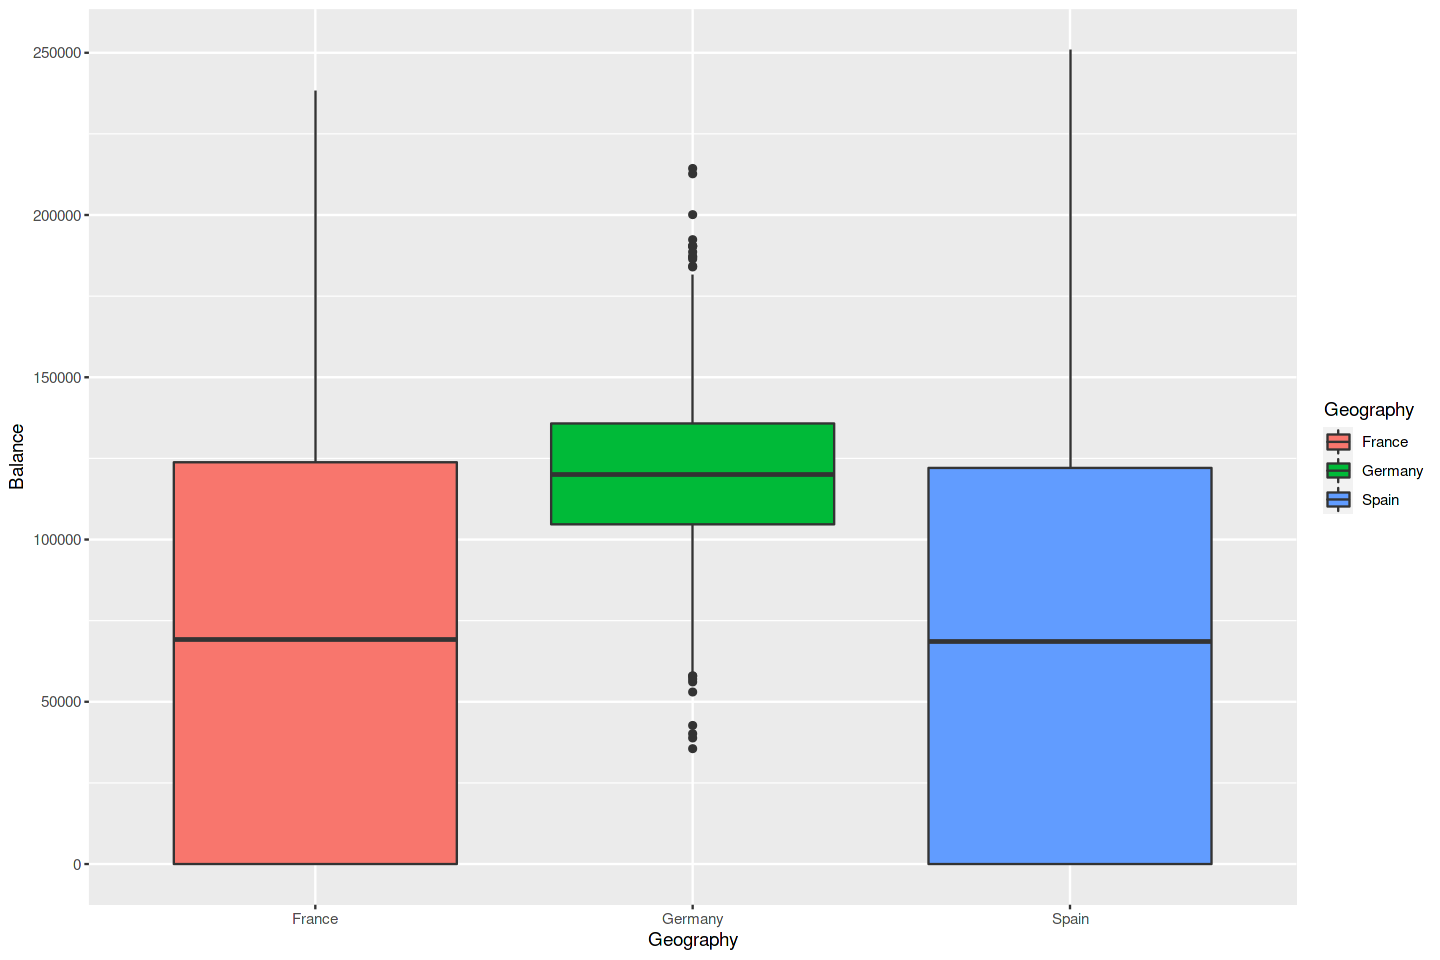

In [18]:
churn_tbl %>% ggplot(., aes(y = Balance, x = Geography, fill = Geography)) + geom_boxplot()

#  Train Test Split

In [19]:
churn_tbl %>% colnames()

[1] "CustomerId"      "CreditScore"     "Geography"       "Gender"         
 [5] "Age"             "Tenure"          "Balance"         "NumOfProducts"  
 [9] "HasCrCard"       "IsActiveMember"  "EstimatedSalary" "Exited"

In [20]:
partition <- churn_tbl %>% mutate(CreditScore = as.numeric(CreditScore),
                     Age = as.numeric(Age),
                     Tenure = as.numeric(Tenure),
                     Balance = as.numeric(Balance),
                     NumOfProducts = as.numeric(NumOfProducts),
                     HasCrCard = as.numeric(HasCrCard),
                     IsActiveMember = as.numeric(IsActiveMember),
                     EstimatedSalary =  as.numeric(EstimatedSalary)) %>%
select(CreditScore,Geography,Gender,Age,Tenure,Balance,
       NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited) %>% 
sdf_partition(train = 0.75, test = 0.25, seed = 123)

Warning message:
“'sdf_partition' is deprecated.
Use 'sdf_random_split' instead.
See help("Deprecated")”


In [21]:
train_tbl <- partition$train
test_tbl <- partition$test

# Spark ML model

###  Logistic Regression

In [22]:
 formula <- colnames(train_tbl %>% select(-Exited)) %>% paste0(collapse = ' + ') %>% 
  paste0('Exited', '~', .) %>% as.formula()

ml_log <- ml_logistic_regression(train_tbl, formula)
ml_log

Formula: Exited ~ CreditScore + Geography + Gender + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary

Coefficients:
      (Intercept)       CreditScore  Geography_France Geography_Germany 
    -2.320993e+00     -1.055792e-03     -1.333068e-02      8.211829e-01 
      Gender_Male               Age            Tenure           Balance 
    -5.600156e-01      7.345205e-02     -5.025631e-03      2.976219e-06 
    NumOfProducts         HasCrCard    IsActiveMember   EstimatedSalary 
    -9.438863e-02     -1.710290e-02     -1.041217e+00      4.983191e-07 

### Decision Tree

In [23]:
ml_dt <- ml_decision_tree(train_tbl, formula)

### Random Forest

In [24]:
ml_rf <-ml_random_forest(train_tbl, formula)

### Gradient Boosted Tree

In [25]:
ml_gbt <- ml_gradient_boosted_trees(train_tbl, formula)

### Naive Bayes

In [26]:
ml_nb <- ml_naive_bayes(train_tbl, formula)

# Model Performance

In [27]:
ml_models <- list("Logistic Regression" = ml_log,
                  "Decision Tree" = ml_dt,
                  "Random Forest" = ml_rf,
                  "Gradient Boosted Tree" = ml_gbt,
                  "Naive Bayes" = ml_nb)

In [28]:
score_test_data <- function(model, data = test_tbl){
    
    pred <- ml_predict(model, data)
    select(pred, Exited, prediction )
}

In [29]:
ml_score <- lapply(ml_models, score_test_data)

In [30]:
ml_score

$`Logistic Regression`
# Source: spark<?> [?? x 2]
   Exited prediction
    <dbl>      <dbl>
 1      1          0
 2      1          1
 3      1          1
 4      1          1
 5      1          1
 6      1          0
 7      0          0
 8      0          1
 9      0          0
10      1          1
# … with more rows
# ℹ Use `print(n = ...)` to see more rows

$`Decision Tree`
# Source: spark<?> [?? x 2]
   Exited prediction
    <dbl>      <dbl>
 1      1     0.453 
 2      1     0.924 
 3      1     0.647 
 4      1     0.933 
 5      1     0.908 
 6      1     0.472 
 7      0     0.0281
 8      0     0.291 
 9      0     0.136 
10      1     0.530 
# … with more rows
# ℹ Use `print(n = ...)` to see more rows

$`Random Forest`
# Source: spark<?> [?? x 2]
   Exited prediction
    <dbl>      <dbl>
 1      1      0.377
 2      1      0.924
 3      1      0.760
 4      1      0.712
 5      1      0.873
 6      1      0.321
 7      0      0.115
 8      0      0.410
 9      0      0.203


In [31]:
calc_accuracy <- function(data, cutpoint = 0.5){
    data %>% mutate(prediction = if_else(prediction > cutpoint, 1.0, 0.0 )) %>%
    ml_classification_eval('prediction', 'Exited', 'accuracy')
}

In [32]:
perf_metric <- data.frame(model = names(ml_score),
                         AUC = 100*sapply(ml_score, ml_binary_classification_evaluator, 'Exited', 'prediction'),
                         Accuracy = 100*sapply(ml_score, calc_accuracy),
                         row.names = NULL, stringsAsFactors = FALSE)

Warning message:
“'ml_classification_eval' is deprecated.
Use 'ml_multiclass_classification_evaluator' instead.
See help("Deprecated")”
Warning message:
“'ml_classification_eval' is deprecated.
Use 'ml_multiclass_classification_evaluator' instead.
See help("Deprecated")”
Warning message:
“'ml_classification_eval' is deprecated.
Use 'ml_multiclass_classification_evaluator' instead.
See help("Deprecated")”
Warning message:
“'ml_classification_eval' is deprecated.
Use 'ml_multiclass_classification_evaluator' instead.
See help("Deprecated")”
Warning message:
“'ml_classification_eval' is deprecated.
Use 'ml_multiclass_classification_evaluator' instead.
See help("Deprecated")”


In [33]:
perf_metric

model,AUC,Accuracy
<chr>,<dbl>,<dbl>
Logistic Regression,70.08829,72.27414
Decision Tree,84.57272,76.71340
Random Forest,86.31019,76.47975
Gradient Boosted Tree,86.07135,78.97196
Naive Bayes,54.14734,54.43925


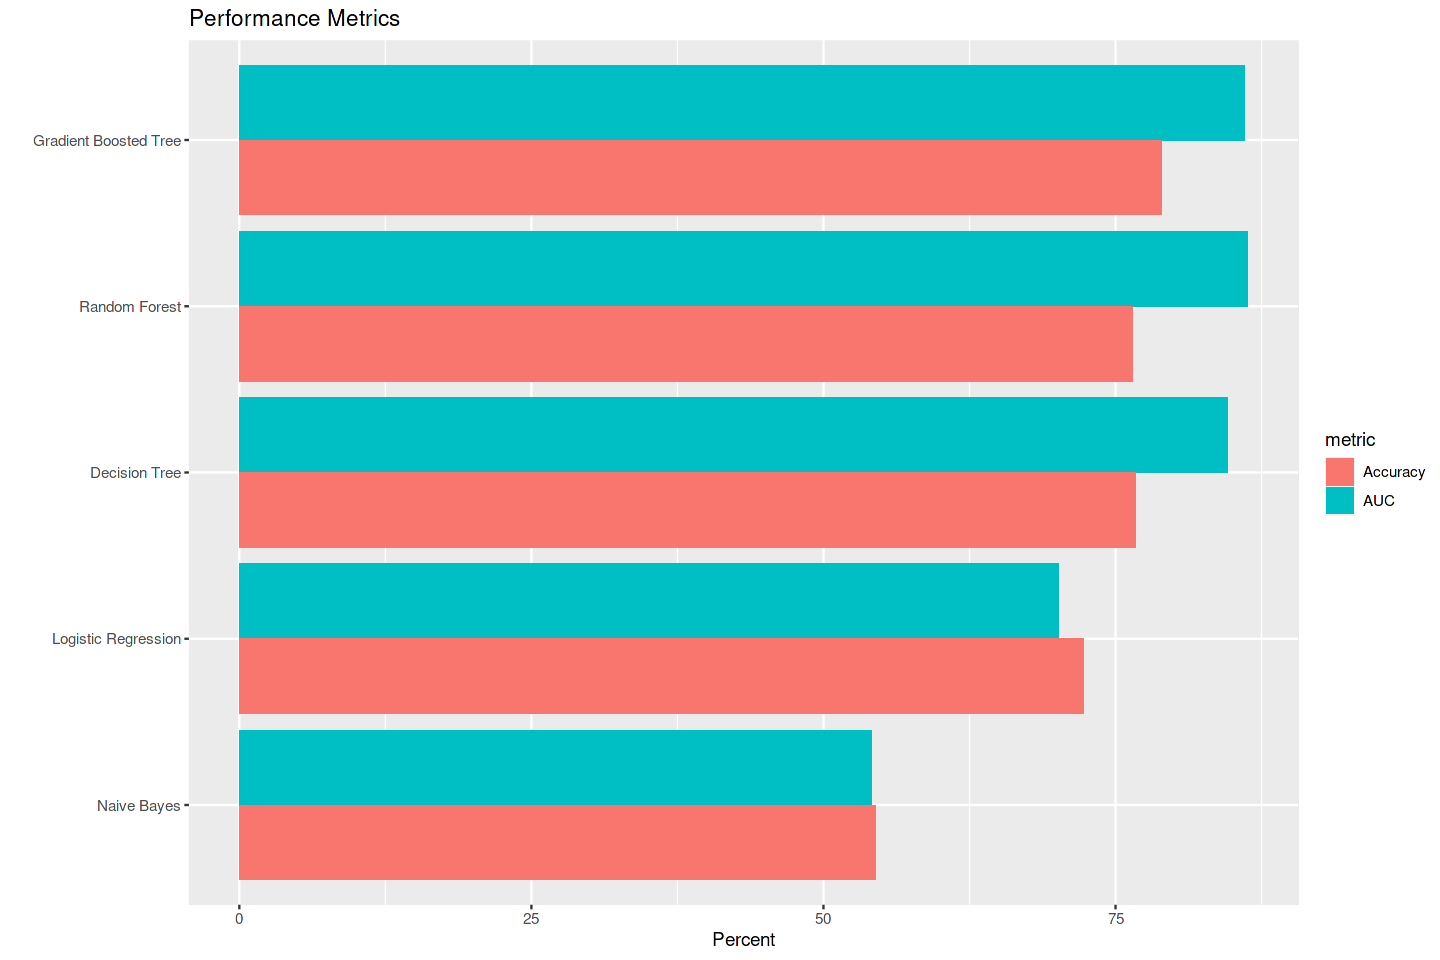

In [34]:
gather(perf_metric, metric, value, AUC, Accuracy) %>%
ggplot(., aes(reorder(model, value), value, fill = metric))+
geom_bar(stat = 'identity', position = 'dodge') + 
coord_flip() + 
xlab(" ") + 
ylab("Percent") +
ggtitle("Performance Metrics")